# **Analysis Sentiment Lexicon Based With Long Short-Term Memory (LSTM) Algorithm**

## **Install Packages**

In [6]:
!pip install tensorflow keras-tuner

In [7]:
!pip install sastrawi
!pip install twint
!pip install scikeras
!pip install vaderSentiment
!pip install googletrans

## **Import Libraries**

In [8]:
import re
import csv
import nltk
import twint
import string
import random
import datetime as dt
import numpy as np
seed = 0
import pandas as pd
pd.options.mode.chained_assignment = None

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid')
import nest_asyncio
nest_asyncio.apply()

# Text Preprocessing
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud

# Feature Extraction
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Splitting Dataset
from sklearn.model_selection import train_test_split

# Modelling
from tensorflow import keras
from keras import layers
from keras.utils import to_categorical
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from scikeras.wrappers import KerasClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score

In [9]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## **Import Dataset**

In [10]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [11]:
df = pd.read_csv('drive/MyDrive/[SKRIPSI]/Datasets/LinkedIn Reviews/5000 LinkedIn Review 2020-2024(Manual Labelling).csv')

## **Exploratory Data Analysis (EDA)**

In [12]:
df.head()

,reviewId,userName,userImage,content,ManualLabelling,score,thumbsUpCount,reviewCreatedVersion,date,replyContent,repliedAt,appVersion,year
0,792af351-0d46-4547-92b4-eaa292ac435f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Tolong di bantu permasalahan nya min, Pas klik...",0.0,4,47,4.1.966,2024-08-03,NaN,NaN,4.1.966,2024
1,1aada824-c4a1-4fe6-bb7d-5bbef12f05bd,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Gua udah punya akun 2 kali dan tiba2 ilang sem...,0.0,1,18,4.1.969,2024-08-19,NaN,NaN,4.1.969,2024
2,62aeacec-a5f2-4452-b9f3-8bb48e05dd74,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Saya tidak login sekitar 1 bulan lebih, dan ke...",0.0,2,15,4.1.972.1,2024-08-16,NaN,NaN,4.1.972.1,2024
3,a9c219b3-d68e-4aa3-afc4-8b562a790264,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Sesuai arahan banyak info loker disini, dan un...",1.0,5,36,4.1.974,2024-08-26,NaN,NaN,4.1.974,2024
4,62d44d7d-0b21-41c8-8a24-6aff661f794b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Suruh verifikasi dengan gambar yang tak jelas,...",0.0,1,122,4.1.966,2024-08-04,NaN,NaN,4.1.966,2024


In [13]:
df.columns

Index(['reviewId', 'userName', 'userImage', 'content', 'ManualLabelling',
       'score', 'thumbsUpCount', 'reviewCreatedVersion', 'date',
       'replyContent', 'repliedAt', 'appVersion', 'year'],
      dtype='object')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviewId              4999 non-null   object 
 1   userName              4999 non-null   object 
 2   userImage             4999 non-null   object 
 3   content               4999 non-null   object 
 4   ManualLabelling       4997 non-null   float64
 5   score                 4999 non-null   int64  
 6   thumbsUpCount         4999 non-null   int64  
 7   reviewCreatedVersion  3756 non-null   object 
 8   date                  4999 non-null   object 
 9   replyContent          631 non-null    object 
 10  repliedAt             631 non-null    object 
 11  appVersion            3756 non-null   object 
 12  year                  4999 non-null   int64  
dtypes: float64(1), int64(3), object(9)
memory usage: 507.8+ KB


In [15]:
df.isnull().sum()

,0
reviewId,0
userName,0
userImage,0
content,0
ManualLabelling,2
score,0
thumbsUpCount,0
reviewCreatedVersion,1243
date,0
replyContent,4368


The columns used or important for sentiment analysis are the content, score, manuallabelling, date and year columns only. So remove the columns that are not used.

In [16]:
df = df.drop(['reviewId', 'userName', 'userImage', 'thumbsUpCount', 'replyContent','repliedAt','reviewCreatedVersion','appVersion', 'score'], axis=1)

In [17]:
def convert_label(label):
  if label == 0.0:
    return "negatif"
  else:
    return "positif"

In [18]:
df['ManualLabelling'] = df['ManualLabelling'].apply(convert_label)

In [19]:
df.head()

,content,ManualLabelling,date,year
0,"Tolong di bantu permasalahan nya min, Pas klik...",negatif,2024-08-03,2024
1,Gua udah punya akun 2 kali dan tiba2 ilang sem...,negatif,2024-08-19,2024
2,"Saya tidak login sekitar 1 bulan lebih, dan ke...",negatif,2024-08-16,2024
3,"Sesuai arahan banyak info loker disini, dan un...",positif,2024-08-26,2024
4,"Suruh verifikasi dengan gambar yang tak jelas,...",negatif,2024-08-04,2024


In [20]:
df = df.rename(columns={'content': 'review'})

In [21]:
df.duplicated().sum()

10

In [22]:
print(df[df.duplicated()])

               review ManualLabelling        date  year
4112  Sangat membantu         positif  2020-07-26  2020
4131  Sangat membantu         positif  2021-10-04  2021
4163  Sangat membantu         positif  2022-02-01  2022
4165  Sangat membantu         positif  2022-01-31  2022
4198  Sangat membantu         positif  2022-01-08  2022
4303  Sangat membantu         positif  2020-10-20  2020
4316  Sangat membantu         positif  2020-09-09  2020
4569  Sangat membantu         positif  2020-01-03  2020
4723     Bagus sekali         positif  2020-04-05  2020
4910            Bagus         positif  2020-04-28  2020


In [23]:
df.drop_duplicates(inplace=True)

In [24]:
df.reset_index(drop=True)

,review,ManualLabelling,date,year
0,"Tolong di bantu permasalahan nya min, Pas klik...",negatif,2024-08-03,2024
1,Gua udah punya akun 2 kali dan tiba2 ilang sem...,negatif,2024-08-19,2024
2,"Saya tidak login sekitar 1 bulan lebih, dan ke...",negatif,2024-08-16,2024
3,"Sesuai arahan banyak info loker disini, dan un...",positif,2024-08-26,2024
4,"Suruh verifikasi dengan gambar yang tak jelas,...",negatif,2024-08-04,2024
...,...,...,...,...
4984,bug recaptcha gajelas,negatif,2023-08-14,2023
4985,Buruk gabisa log in,negatif,2024-02-12,2024
4986,Amazing... good luck 👍👍,positif,2022-03-28,2022
4987,"keren abis, thanks linkedIn",positif,2020-05-13,2020


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4989 entries, 0 to 4998
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   review           4989 non-null   object
 1   ManualLabelling  4989 non-null   object
 2   date             4989 non-null   object
 3   year             4989 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 194.9+ KB


### **Plot the Distribution of Review By Year**

<ipython-input-26-1f485dfdaee2>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='year', data=df, palette='Set2')


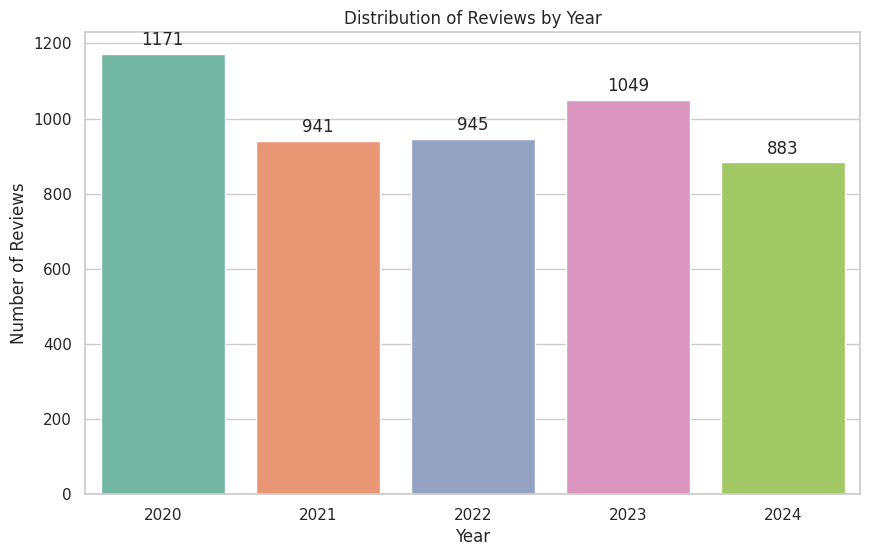

In [26]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='year', data=df, palette='Set2')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points')
plt.title('Distribution of Reviews by Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.show()

In [27]:
df = df.copy()

## **Text Preprocessing**

### **Case Folding**

In [28]:
def lowercase(review_text):
  low = review_text.lower()
  return low

In [29]:
df['clean_review'] = df['review'].apply(lambda low:lowercase(str(low)))

### **Cleaning**

In [30]:
def remove_emoji(review_text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', review_text)

In [31]:
df['clean_review'] = df['clean_review'].apply(lambda emoji: remove_emoji(emoji))

In [32]:
def remove_number(review_text, default_replace=" "):
  num = re.sub(r'\d+', default_replace, review_text)
  return num

In [33]:
df['clean_review'] = df['clean_review'].apply(lambda num: remove_number(num))

In [34]:
def remove_punctuation(review_text, default_text=" "):
  list_punct = string.punctuation
  delete_punct = str.maketrans(list_punct,' '*len(list_punct))
  new_review = ' '.join(review_text.translate(delete_punct).split())
  return new_review

In [35]:
df['clean_review'] = df['clean_review'].apply(lambda punct: remove_punctuation(punct))

In [36]:
def remove_extra_whitespaces(review_text):
  review = re.sub(r'\s+',' ', review_text)
  return review

In [37]:
df['clean_review'] = df['clean_review'].apply(lambda extra_spaces: remove_extra_whitespaces(extra_spaces))

In [38]:
df['before_cleaning'] = df['review'].apply(lambda x: len(str(x).split()))
df['after_cleaning'] = df['clean_review'].apply(lambda x: len(str(x).split()))

word_count_df = df[['review', 'clean_review', 'before_cleaning', 'after_cleaning']]

In [39]:
df.head()

,review,ManualLabelling,date,year,clean_review,before_cleaning,after_cleaning
0,"Tolong di bantu permasalahan nya min, Pas klik...",negatif,2024-08-03,2024,tolong di bantu permasalahan nya min pas klik ...,79,78
1,Gua udah punya akun 2 kali dan tiba2 ilang sem...,negatif,2024-08-19,2024,gua udah punya akun kali dan tiba ilang semua ...,47,46
2,"Saya tidak login sekitar 1 bulan lebih, dan ke...",negatif,2024-08-16,2024,saya tidak login sekitar bulan lebih dan ketik...,39,38
3,"Sesuai arahan banyak info loker disini, dan un...",positif,2024-08-26,2024,sesuai arahan banyak info loker disini dan unt...,28,28
4,"Suruh verifikasi dengan gambar yang tak jelas,...",negatif,2024-08-04,2024,suruh verifikasi dengan gambar yang tak jelas ...,34,34


### **Normalization**

In [40]:
slangs = open('drive/MyDrive/[SKRIPSI]/Datasets/Slang Corpus/slang.txt',"r",encoding="utf-8", errors='replace')

In [41]:
clear_slangs= []
for newlines in slangs:
  strip_re = newlines.strip("\n")
  split = re.split(r'[:]',strip_re)
  clear_slangs.append(split)

print(clear_slangs)
len(clear_slangs)

[['& ', ' dan'], ['dr ', ' dari'], ['abis ', ' habis'], ['ad ', ' ada'], ['alhmdulillah ', ' alhamdulillah'], ['alhamdulilah ', ' alhamdulillah'], ['alhamdulillaah ', ' alhamdulillah'], ['alhamdulillah ', ' alhamdulillah'], ['adminnya ', ' admin nya'], ['account ', ' akun'], ['asiikk ', ' asyik'], ['alpukatnya ', ' alpukat nya'], ['amin ', ' aamiin'], ['aplikasinnya ', ' aplikasi nya'], ['aplikasinya ', ' aplikasi nya'], ['app ', ' aplikasi'], ['apk ', ' aplikasi'], ['apps ', ' aplikasi'], ['apl ', ' aplikasi'], ['awesome ', ' luar biasa'], ['asyilk ', ' asyik'], ['antaran ', ' pengantaran'], ['apus ', ' hapus'], ['ampe ', ' sampai'], ['almt ', ' alamat'], ['almat ', ' alamat'], ['alamt ', ' alamat'], ['almtnya ', ' alamatnya'], ['apknya ', ' aplikasinya'], ['antri ', ' antre'], ['adl ', ' adalah'], ['awalnnya ', ' awalnya'], ['asem ', ' asam'], ['alumunium ', ' aluminium'], ['abis ', ' habis'], ['areaku ', ' area saya'], ['alpulat ', ' alpukat'], ['adlah ', ' adalah'], ['applikasi ', 

1923

In [42]:
slangs = [[k.strip(), v.strip()] for k,v in clear_slangs]
dict_slangs = {key:values for key,values in slangs}

In [43]:
clean_text = []
for review in df['clean_review']:
  wordlist = TextBlob(review).words
  for k,v in enumerate(wordlist):
    if v in dict_slangs.keys():
      wordlist[k] = dict_slangs[v]
  clean_text.append(' '.join(wordlist))

In [44]:
df['normalized_review'] = clean_text

In [45]:
df['before_normalizing'] = df['clean_review'].apply(lambda x: len(str(x).split()))
df['after_normalizing'] = df['normalized_review'].apply(lambda x: len(str(x).split()))

word_count_df = df[['review', 'clean_review', 'before_normalizing', 'after_normalizing']]

In [46]:
df.tail(10)

,review,ManualLabelling,date,year,clean_review,before_cleaning,after_cleaning,normalized_review,before_normalizing,after_normalizing
4989,Ok banget.!!!,positif,2023-04-04,2023,ok banget,2,2,oke banget,2,2
4990,"LinkedIn, ok dahh!",positif,2022-05-04,2022,linkedin ok dahh,3,3,linkedin oke deh,3,3
4991,"Good app, sangat membantu",positif,2022-08-05,2022,good app sangat membantu,4,4,bagus aplikasi sangat membantu,4,4
4992,GAK guna !,negatif,2022-07-05,2022,gak guna,3,2,tidak guna,2,2
4993,Iklan mulu gateli bangsat,negatif,2024-05-30,2024,iklan mulu gateli bangsat,4,4,iklan mulu gateli bangsat,4,4
4994,bug recaptcha gajelas,negatif,2023-08-14,2023,bug recaptcha gajelas,3,3,bug recaptcha tidak jelas,3,4
4995,Buruk gabisa log in,negatif,2024-02-12,2024,buruk gabisa log in,4,4,buruk tidak bisa log in,4,5
4996,Amazing... good luck 👍👍,positif,2022-03-28,2022,amazing good luck,4,3,amazing bagus luck,3,3
4997,"keren abis, thanks linkedIn",positif,2020-05-13,2020,keren abis thanks linkedin,4,4,keren habis terima kasih linkedin,4,5
4998,Ngelooping data verifikasi,negatif,2023-05-04,2023,ngelooping data verifikasi,3,3,ngelooping data verifikasi,3,3


### **Tokenization**

In [47]:
def word_token(review_text):
  return word_tokenize(review_text)

In [48]:
df['tokenize_review'] = df['normalized_review'].apply(lambda tokenize:word_token(str(tokenize)))

### **Stopwords Removal**

In [49]:
indo_stopwords = open('drive/MyDrive/[SKRIPSI]/Datasets/Indonesian Stopwords/indonesian-stopwords.txt',"r",encoding="utf-8", errors='replace')

In [50]:
stop_words = set(indo_stopwords.read().splitlines())

In [51]:
len(stop_words)

755

In [52]:
def remove_stopwords(review_text):
  filtered_sentence = [w for w in review_text if not w in stop_words]
  return filtered_sentence

In [53]:
df['standardlized_review'] = df['tokenize_review'].apply(lambda stopwords: remove_stopwords(stopwords))

In [54]:
df['before_stopwords'] = df['tokenize_review'].apply(lambda x: len(str(x).split()))
df['after_stopwords'] = df['standardlized_review'].apply(lambda x: len(str(x).split()))

word_count_df = df[['tokenize_review', 'standardlized_review', 'before_stopwords', 'after_stopwords']]

In [55]:
df.head()

,review,ManualLabelling,date,year,clean_review,before_cleaning,after_cleaning,normalized_review,before_normalizing,after_normalizing,tokenize_review,standardlized_review,before_stopwords,after_stopwords
0,"Tolong di bantu permasalahan nya min, Pas klik...",negatif,2024-08-03,2024,tolong di bantu permasalahan nya min pas klik ...,79,78,tolong di bantu permasalahan nya minimal pas k...,78,78,"[tolong, di, bantu, permasalahan, nya, minimal...","[tolong, bantu, permasalahan, nya, minimal, pa...",78,51
1,Gua udah punya akun 2 kali dan tiba2 ilang sem...,negatif,2024-08-19,2024,gua udah punya akun kali dan tiba ilang semua ...,47,46,saya sudah punya akun kali dan tiba hilang sem...,46,46,"[saya, sudah, punya, akun, kali, dan, tiba, hi...","[akun, kali, hilang, suruh, login, coba, tidak...",46,17
2,"Saya tidak login sekitar 1 bulan lebih, dan ke...",negatif,2024-08-16,2024,saya tidak login sekitar bulan lebih dan ketik...,39,38,saya tidak login sekitar bulan lebih dan ketik...,38,38,"[saya, tidak, login, sekitar, bulan, lebih, da...","[tidak, login, login, verifikasi, memasukkan, ...",38,16
3,"Sesuai arahan banyak info loker disini, dan un...",positif,2024-08-26,2024,sesuai arahan banyak info loker disini dan unt...,28,28,sesuai arahan banyak informasi loker disini da...,28,28,"[sesuai, arahan, banyak, informasi, loker, dis...","[sesuai, arahan, informasi, loker, untungnya, ...",28,15
4,"Suruh verifikasi dengan gambar yang tak jelas,...",negatif,2024-08-04,2024,suruh verifikasi dengan gambar yang tak jelas ...,34,34,suruh verifikasi dengan gambar yang tidak jela...,34,34,"[suruh, verifikasi, dengan, gambar, yang, tida...","[suruh, verifikasi, gambar, tidak, tidak, kode...",34,19


In [56]:
df['stopwords_removed_count'] = df['before_stopwords'] - df['after_stopwords']
df_sorted = df.sort_values('stopwords_removed_count', ascending=False)

### **Stemming**

In [57]:
def stem_review(review_text):
  stop_token = ' '.join(review_text)
  stem = StemmerFactory()
  create_stem = stem.create_stemmer()
  result_stem = create_stem.stem(stop_token)
  return result_stem

In [58]:
df['stemmed_review'] = df['standardlized_review'].apply(lambda stem:stem_review(stem))

In [59]:
df['before_stemming'] = df['standardlized_review'].apply(lambda x: len(str(x).split()))
df['after_stemming'] = df['stemmed_review'].apply(lambda x: len(str(x).split()))

word_count_df = df[['standardlized_review', 'stemmed_review', 'before_stopwords', 'after_stopwords']]

In [60]:
df.head(10)

,review,ManualLabelling,date,year,clean_review,before_cleaning,after_cleaning,normalized_review,before_normalizing,after_normalizing,tokenize_review,standardlized_review,before_stopwords,after_stopwords,stopwords_removed_count,stemmed_review,before_stemming,after_stemming
0,"Tolong di bantu permasalahan nya min, Pas klik...",negatif,2024-08-03,2024,tolong di bantu permasalahan nya min pas klik ...,79,78,tolong di bantu permasalahan nya minimal pas k...,78,78,"[tolong, di, bantu, permasalahan, nya, minimal...","[tolong, bantu, permasalahan, nya, minimal, pa...",78,51,27,tolong bantu masalah nya minimal pas klik tamp...,51,51
1,Gua udah punya akun 2 kali dan tiba2 ilang sem...,negatif,2024-08-19,2024,gua udah punya akun kali dan tiba ilang semua ...,47,46,saya sudah punya akun kali dan tiba hilang sem...,46,46,"[saya, sudah, punya, akun, kali, dan, tiba, hi...","[akun, kali, hilang, suruh, login, coba, tidak...",46,17,29,akun kali hilang suruh login coba tidak baru t...,17,17
2,"Saya tidak login sekitar 1 bulan lebih, dan ke...",negatif,2024-08-16,2024,saya tidak login sekitar bulan lebih dan ketik...,39,38,saya tidak login sekitar bulan lebih dan ketik...,38,38,"[saya, tidak, login, sekitar, bulan, lebih, da...","[tidak, login, login, verifikasi, memasukkan, ...",38,16,22,tidak login login verifikasi masuk password ve...,16,16
3,"Sesuai arahan banyak info loker disini, dan un...",positif,2024-08-26,2024,sesuai arahan banyak info loker disini dan unt...,28,28,sesuai arahan banyak informasi loker disini da...,28,28,"[sesuai, arahan, banyak, informasi, loker, dis...","[sesuai, arahan, informasi, loker, untungnya, ...",28,15,13,sesuai arah informasi loker untung trouble int...,15,15
4,"Suruh verifikasi dengan gambar yang tak jelas,...",negatif,2024-08-04,2024,suruh verifikasi dengan gambar yang tak jelas ...,34,34,suruh verifikasi dengan gambar yang tidak jela...,34,34,"[suruh, verifikasi, dengan, gambar, yang, tida...","[suruh, verifikasi, gambar, tidak, tidak, kode...",34,19,15,suruh verifikasi gambar tidak tidak kode verif...,19,19
5,"Menyusahkan. Perkara lupa nulis password, akun...",negatif,2024-07-31,2024,menyusahkan perkara lupa nulis password akun b...,43,42,menyusahkan perkara lupa nulis password akun b...,42,42,"[menyusahkan, perkara, lupa, nulis, password, ...","[menyusahkan, perkara, lupa, nulis, password, ...",42,31,11,susah perkara lupa nulis password akun bikin k...,31,31
6,"Aplikasi ga jeelassss,.makin lama makin ngebug...",negatif,2024-06-25,2024,aplikasi ga jeelassss makin lama makin ngebug ...,20,24,aplikasi tidak jeelassss makin lama makin nge ...,24,25,"[aplikasi, tidak, jeelassss, makin, lama, maki...","[aplikasi, tidak, jeelassss, nge, bug, login, ...",25,15,10,aplikasi tidak jeelassss nge bug login suruh v...,15,15
7,aplikasi yang top untuk melihat jaringan karie...,positif,2024-07-18,2024,aplikasi yang top untuk melihat jaringan karie...,25,24,aplikasi yang top untuk melihat jaringan karie...,24,25,"[aplikasi, yang, top, untuk, melihat, jaringan...","[aplikasi, top, jaringan, karier, luas, aplika...",25,15,10,aplikasi top jaring karier luas aplikasi bagus...,15,15
8,Aplikasi LinkedIn logout sendiri dan meminta v...,negatif,2024-07-19,2024,aplikasi linkedin logout sendiri dan meminta v...,28,28,aplikasi linkedin logout sendiri dan meminta v...,28,28,"[aplikasi, linkedin, logout, sendiri, dan, mem...","[aplikasi, linkedin, logout, verifikasi, wajah...",28,19,9,aplikasi linkedin logout verifikasi wajah data...,19,19
9,Verivikasi kenapa ngga pakai nomor telfon atau...,negatif,2024-08-14,2024,verivikasi kenapa ngga pakai nomor telfon atau...,42,45,verivikasi kenapa tidak pakai nomor telpon ata...,45,46,"[verivikasi, kenapa, tidak, pakai, nomor, telp...","[verivikasi, tidak, pakai, nomor, telpon, emai...",46,24,22,verivikasi tidak pakai nomor telpon email taut...,24,24


In [61]:
df.to_csv('drive/MyDrive/[SKRIPSI]/Datasets/5000 LinkedIn Reviews Preprocessed.csv', index=False)

## **Labelling with Indonesian Sentiment (InSet) Lexicon**

In [62]:
lexicon_positive = dict()
with open('drive/MyDrive/[SKRIPSI]/Datasets/InSet Lexicon/lexicon_positive_ver1.csv', 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  for row in reader:
    lexicon_positive[row[0]] = int(row[1])

In [63]:
lexicon_negative = dict()
with open('drive/MyDrive/[SKRIPSI]/Datasets/InSet Lexicon/lexicon_negative_ver1.csv', 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  for row in reader:
    lexicon_negative[row[0]] = int(row[1])

In [64]:
def sentiment_analysis_lexicon_indonesia(text):
  score = 0
  for word_pos in text:
    if (word_pos in lexicon_positive):
      score = score + lexicon_positive[word_pos]
  for word_neg in text:
    if (word_neg in lexicon_negative):
      score = score + lexicon_negative[word_neg]
  polarity=''
  if (score > 0):
    polarity = 'positif'
  else:
    polarity = 'negatif'

  return score, polarity

In [65]:
df['inset_lex'] = df['stemmed_review'].astype(str).str.split()

In [66]:
df = df.rename(columns={'inset_lex': 'preprocessed_review'})

In [67]:
results = df['preprocessed_review'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))

In [68]:
df['polarity_score'] = results[0]

In [69]:
df['polarity'] = results[1]

In [70]:
df = df.rename(columns={'polarity': 'inset_results'})

In [71]:
df = df.replace('',np.nan, regex=True)
df = df.dropna()

In [72]:
df = df.reset_index(drop=True)

In [73]:
print(df['inset_results'].value_counts())

inset_results
positif    2731
negatif    2223
Name: count, dtype: int64


In [74]:
print(df['ManualLabelling'].value_counts())

ManualLabelling
positif    2756
negatif    2198
Name: count, dtype: int64


In [75]:
top_5_negative_reviews = df[df['inset_results'] == 'negatif'].head(5)
top_5_negative_reviews

,review,ManualLabelling,date,year,clean_review,before_cleaning,after_cleaning,normalized_review,before_normalizing,after_normalizing,...,standardlized_review,before_stopwords,after_stopwords,stopwords_removed_count,stemmed_review,before_stemming,after_stemming,preprocessed_review,polarity_score,inset_results
0,"Tolong di bantu permasalahan nya min, Pas klik...",negatif,2024-08-03,2024,tolong di bantu permasalahan nya min pas klik ...,79,78,tolong di bantu permasalahan nya minimal pas k...,78,78,...,"[tolong, bantu, permasalahan, nya, minimal, pa...",78,51,27,tolong bantu masalah nya minimal pas klik tamp...,51,51,"[tolong, bantu, masalah, nya, minimal, pas, kl...",-23,negatif
1,Gua udah punya akun 2 kali dan tiba2 ilang sem...,negatif,2024-08-19,2024,gua udah punya akun kali dan tiba ilang semua ...,47,46,saya sudah punya akun kali dan tiba hilang sem...,46,46,...,"[akun, kali, hilang, suruh, login, coba, tidak...",46,17,29,akun kali hilang suruh login coba tidak baru t...,17,17,"[akun, kali, hilang, suruh, login, coba, tidak...",-33,negatif
2,"Saya tidak login sekitar 1 bulan lebih, dan ke...",negatif,2024-08-16,2024,saya tidak login sekitar bulan lebih dan ketik...,39,38,saya tidak login sekitar bulan lebih dan ketik...,38,38,...,"[tidak, login, login, verifikasi, memasukkan, ...",38,16,22,tidak login login verifikasi masuk password ve...,16,16,"[tidak, login, login, verifikasi, masuk, passw...",-27,negatif
4,"Suruh verifikasi dengan gambar yang tak jelas,...",negatif,2024-08-04,2024,suruh verifikasi dengan gambar yang tak jelas ...,34,34,suruh verifikasi dengan gambar yang tidak jela...,34,34,...,"[suruh, verifikasi, gambar, tidak, tidak, kode...",34,19,15,suruh verifikasi gambar tidak tidak kode verif...,19,19,"[suruh, verifikasi, gambar, tidak, tidak, kode...",-29,negatif
5,"Menyusahkan. Perkara lupa nulis password, akun...",negatif,2024-07-31,2024,menyusahkan perkara lupa nulis password akun b...,43,42,menyusahkan perkara lupa nulis password akun b...,42,42,...,"[menyusahkan, perkara, lupa, nulis, password, ...",42,31,11,susah perkara lupa nulis password akun bikin k...,31,31,"[susah, perkara, lupa, nulis, password, akun, ...",-32,negatif


In [76]:
top_5_positif_reviews = df[df['inset_results'] == 'positif'].head(5)
top_5_positif_reviews

,review,ManualLabelling,date,year,clean_review,before_cleaning,after_cleaning,normalized_review,before_normalizing,after_normalizing,...,standardlized_review,before_stopwords,after_stopwords,stopwords_removed_count,stemmed_review,before_stemming,after_stemming,preprocessed_review,polarity_score,inset_results
3,"Sesuai arahan banyak info loker disini, dan un...",positif,2024-08-26,2024,sesuai arahan banyak info loker disini dan unt...,28,28,sesuai arahan banyak informasi loker disini da...,28,28,...,"[sesuai, arahan, informasi, loker, untungnya, ...",28,15,13,sesuai arah informasi loker untung trouble int...,15,15,"[sesuai, arah, informasi, loker, untung, troub...",9,positif
7,aplikasi yang top untuk melihat jaringan karie...,positif,2024-07-18,2024,aplikasi yang top untuk melihat jaringan karie...,25,24,aplikasi yang top untuk melihat jaringan karie...,24,25,...,"[aplikasi, top, jaringan, karier, luas, aplika...",25,15,10,aplikasi top jaring karier luas aplikasi bagus...,15,15,"[aplikasi, top, jaring, karier, luas, aplikasi...",13,positif
14,"Aplikasi makin sering update makin berat, sist...",negatif,2024-04-25,2024,aplikasi makin sering update makin berat siste...,46,46,aplikasi makin sering diperbarui makin berat s...,46,47,...,"[aplikasi, diperbarui, berat, sistem, ui, nya,...",47,33,14,aplikasi baru berat sistem ui nya bagus terkad...,33,33,"[aplikasi, baru, berat, sistem, ui, nya, bagus...",12,positif
18,padahal gaada niatan mau berlangganan dipencet...,negatif,2024-07-26,2024,padahal gaada niatan mau berlangganan dipencet...,44,47,padahal tidak ada niatan mau berlangganan dipe...,47,48,...,"[tidak, niatan, berlangganan, dipencet, berlan...",48,25,23,tidak niat langgan pencet langgan tidak saldo ...,25,25,"[tidak, niat, langgan, pencet, langgan, tidak,...",6,positif
24,"Kalo tidak bisa dibuka itu bagaimana ya min, m...",negatif,2024-06-25,2024,kalo tidak bisa dibuka itu bagaimana ya min mo...,19,19,kalau tidak bisa dibuka itu bagaimana ya minim...,19,20,...,"[tidak, dibuka, ya, minimal, mohon, pencerahan...",20,13,7,tidak buka ya minimal mohon pencerahanya kemar...,13,13,"[tidak, buka, ya, minimal, mohon, pencerahanya...",1,positif


### **Evaluate Lexicon**

In [77]:
cm_lexicon = confusion_matrix(df['ManualLabelling'], df['inset_results'])

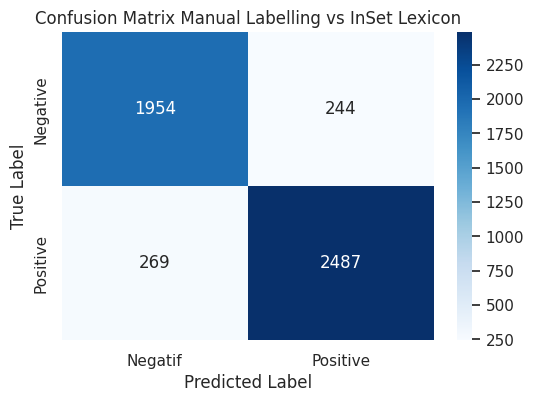

In [78]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lexicon, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix Manual Labelling vs InSet Lexicon')
plt.show()

In [79]:
print(classification_report(df['ManualLabelling'], df['inset_results']))

              precision    recall  f1-score   support

     negatif       0.88      0.89      0.88      2198
     positif       0.91      0.90      0.91      2756

    accuracy                           0.90      4954
   macro avg       0.89      0.90      0.90      4954
weighted avg       0.90      0.90      0.90      4954



In [80]:
accuracy = accuracy_score(df['ManualLabelling'], df['inset_results'])
precision = precision_score(df['ManualLabelling'], df['inset_results'], average='macro')
recall = recall_score(df['ManualLabelling'], df['inset_results'], average='macro')
f1_score = f1_score(df['ManualLabelling'], df['inset_results'], average='macro')

In [81]:
print(f'Accuracy : {accuracy * 100:.2f}%')
print(f'Precision : {precision:.2f}')
print(f'Recall : {recall:.2f}')
print(f'F1 Score : {f1_score:.2f}')

Accuracy : 89.64%
Precision : 0.89
Recall : 0.90
F1 Score : 0.90


### **Sentiment Distribution in Each Year (Manual Labelling)**

#### **2020**

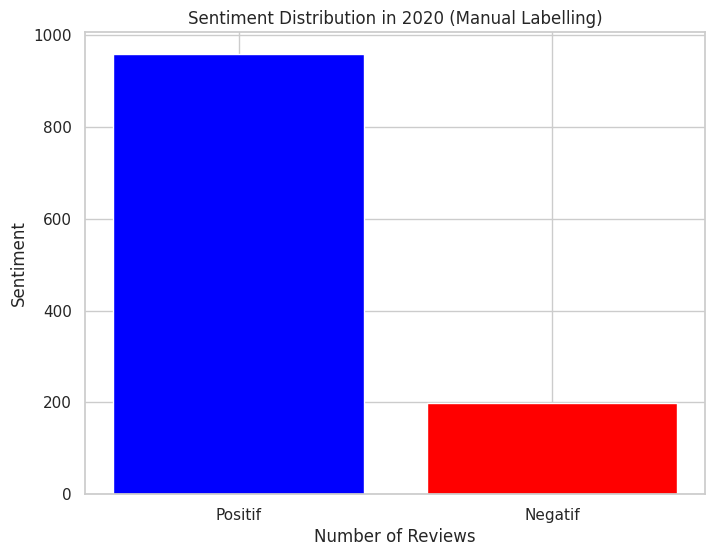

In [82]:
df_2020 = df[df['year'] == 2020]
sentiment_counts_2020 = df_2020['ManualLabelling'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(['Positif', 'Negatif'], sentiment_counts_2020.values, color=['blue', 'red'])
plt.xlabel('Number of Reviews')
plt.ylabel('Sentiment')
plt.title('Sentiment Distribution in 2020 (Manual Labelling)')
plt.show()

#### **2021**

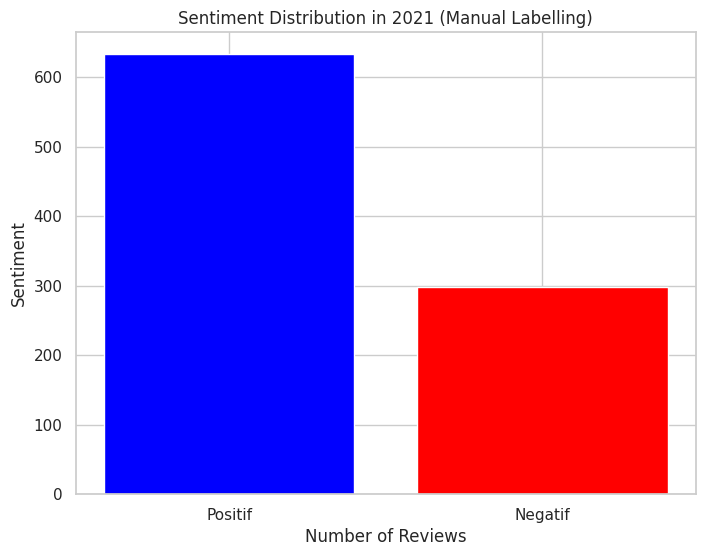

In [83]:
df_2021 = df[df['year'] == 2021]
sentiment_counts_2021 = df_2021['ManualLabelling'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(['Positif', 'Negatif'], sentiment_counts_2021.values, color=['blue', 'red'])
plt.xlabel('Number of Reviews')
plt.ylabel('Sentiment')
plt.title('Sentiment Distribution in 2021 (Manual Labelling)')
plt.show()

#### **2022**

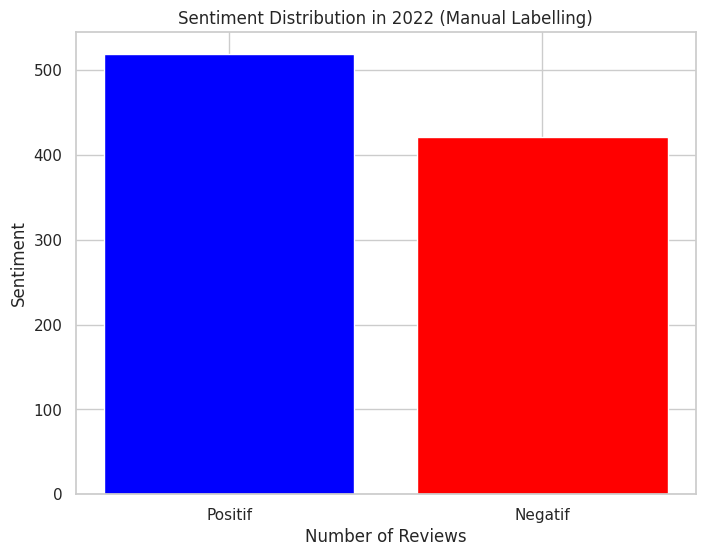

In [84]:
df_2022 = df[df['year'] == 2022]
sentiment_counts_2022 = df_2022['ManualLabelling'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(['Positif', 'Negatif'], sentiment_counts_2022.values, color=['blue', 'red'])
plt.xlabel('Number of Reviews')
plt.ylabel('Sentiment')
plt.title('Sentiment Distribution in 2022 (Manual Labelling)')
plt.show()

#### **2023**

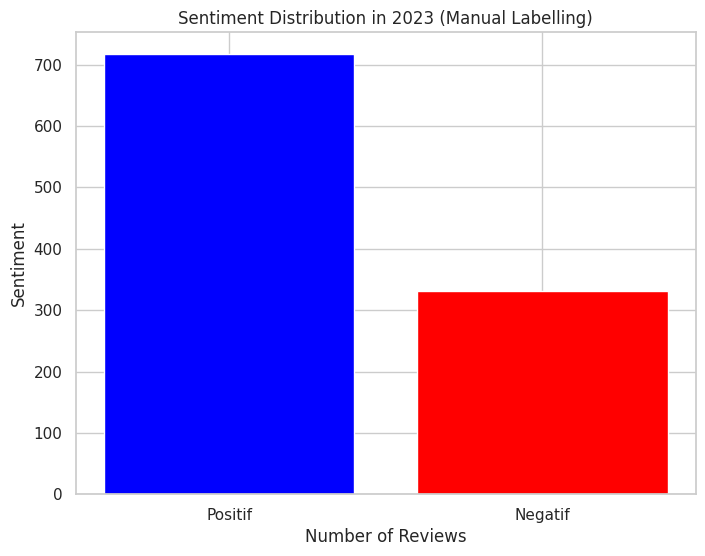

In [85]:
df_2023 = df[df['year'] == 2023]
sentiment_counts_2023 = df_2023['ManualLabelling'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(['Positif', 'Negatif'], sentiment_counts_2023.values, color=['blue', 'red'])
plt.xlabel('Number of Reviews')
plt.ylabel('Sentiment')
plt.title('Sentiment Distribution in 2023 (Manual Labelling)')
plt.show()

#### **2024**

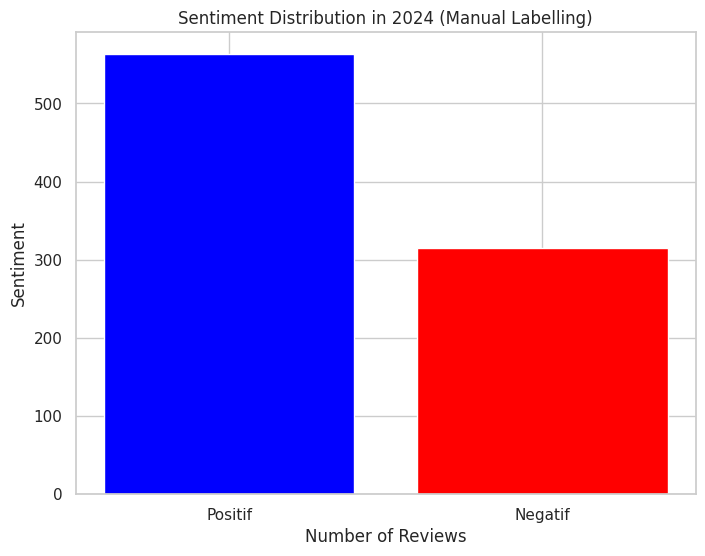

In [86]:
df_2024 = df[df['year'] == 2024]
sentiment_counts_2024 = df_2024['ManualLabelling'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(['Positif', 'Negatif'], sentiment_counts_2024.values, color=['blue', 'red'])
plt.xlabel('Number of Reviews')
plt.ylabel('Sentiment')
plt.title('Sentiment Distribution in 2024 (Manual Labelling)')
plt.show()

### **Sentiment Distribution in Each Year (InSet Lexicon)**

#### **2020**

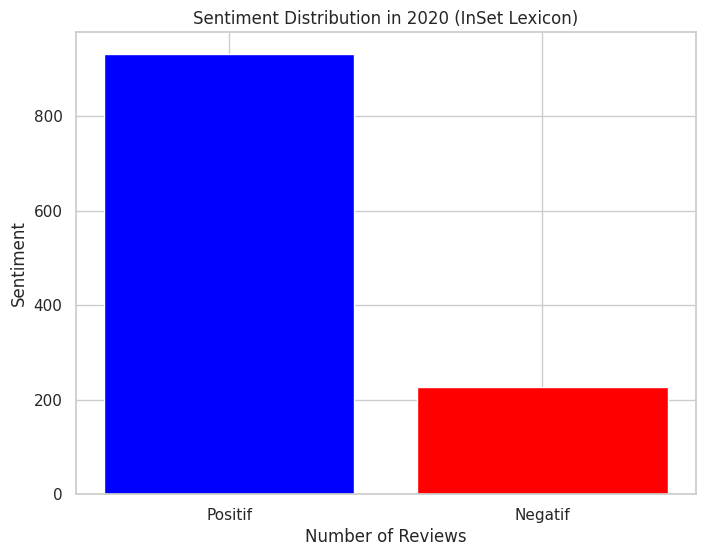

In [87]:
df1_2020 = df[df['year'] == 2020]
sentiment_counts_20201 = df1_2020['inset_results'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(['Positif', 'Negatif'], sentiment_counts_20201.values, color=['blue', 'red'])
plt.xlabel('Number of Reviews')
plt.ylabel('Sentiment')
plt.title('Sentiment Distribution in 2020 (InSet Lexicon)')
plt.show()

#### **2021**

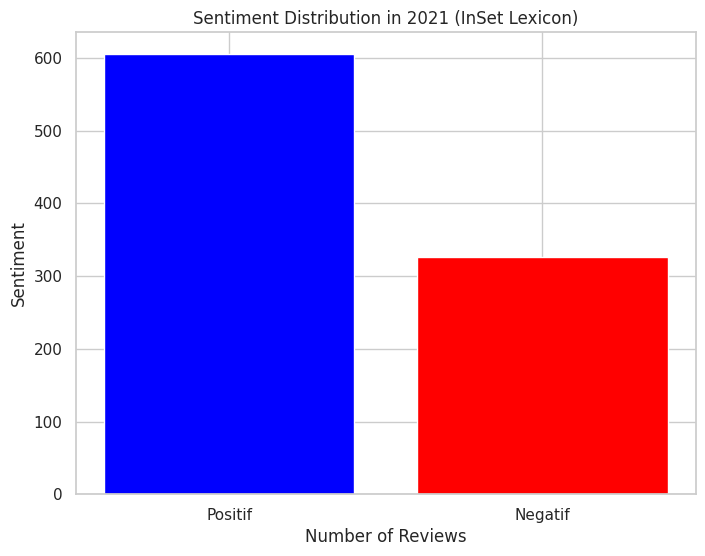

In [88]:
df1_2021 = df[df['year'] == 2021]
sentiment_counts_20211 = df1_2021['inset_results'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(['Positif', 'Negatif'], sentiment_counts_20211.values, color=['blue', 'red'])
plt.xlabel('Number of Reviews')
plt.ylabel('Sentiment')
plt.title('Sentiment Distribution in 2021 (InSet Lexicon)')
plt.show()

#### **2022**

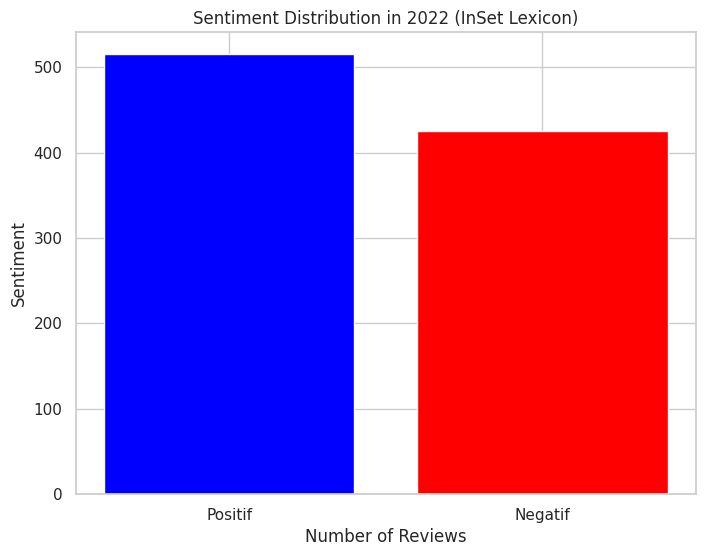

In [89]:
df1_2022 = df[df['year'] == 2022]
sentiment_counts_20221 = df1_2022['inset_results'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(['Positif', 'Negatif'], sentiment_counts_20221.values, color=['blue', 'red'])
plt.xlabel('Number of Reviews')
plt.ylabel('Sentiment')
plt.title('Sentiment Distribution in 2022 (InSet Lexicon)')
plt.show()

#### **2023**

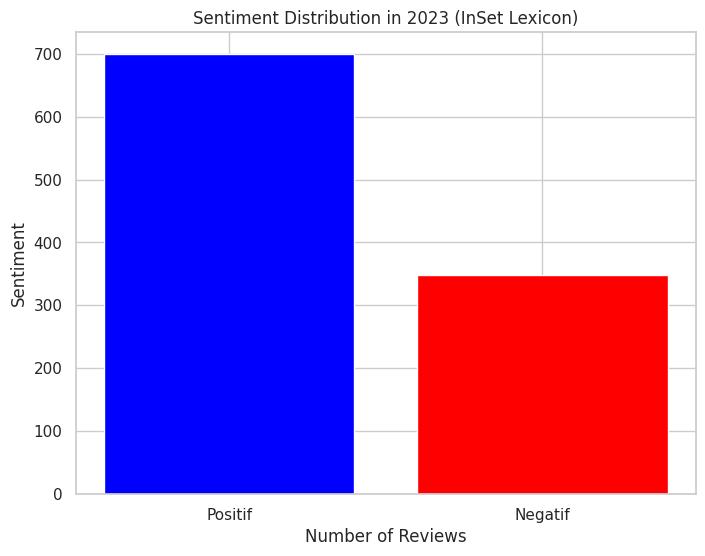

In [90]:
df1_2023 = df[df['year'] == 2023]
sentiment_counts_20231 = df1_2023['inset_results'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(['Positif', 'Negatif'], sentiment_counts_20231.values, color=['blue', 'red'])
plt.xlabel('Number of Reviews')
plt.ylabel('Sentiment')
plt.title('Sentiment Distribution in 2023 (InSet Lexicon)')
plt.show()

#### **2024**

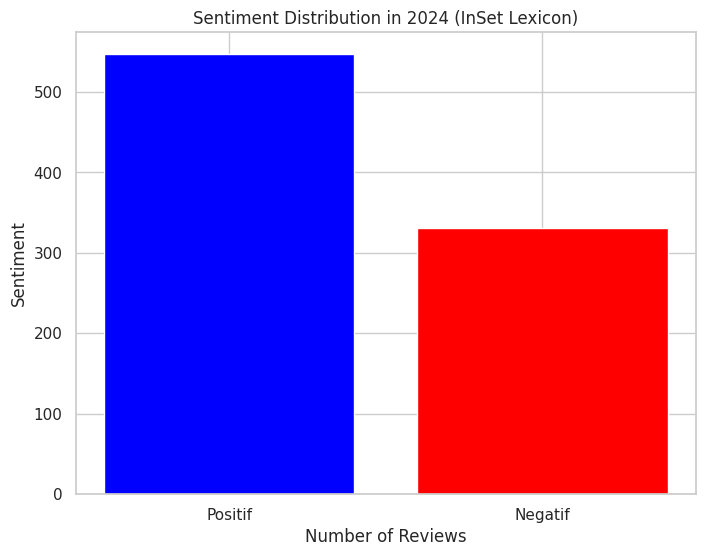

In [91]:
df1_2024 = df[df['year'] == 2024]
sentiment_counts_20241 = df1_2024['inset_results'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(['Positif', 'Negatif'], sentiment_counts_20241.values, color=['blue', 'red'])
plt.xlabel('Number of Reviews')
plt.ylabel('Sentiment')
plt.title('Sentiment Distribution in 2024 (InSet Lexicon)')
plt.show()

### **Plotting**

#### **Manual Labelling**

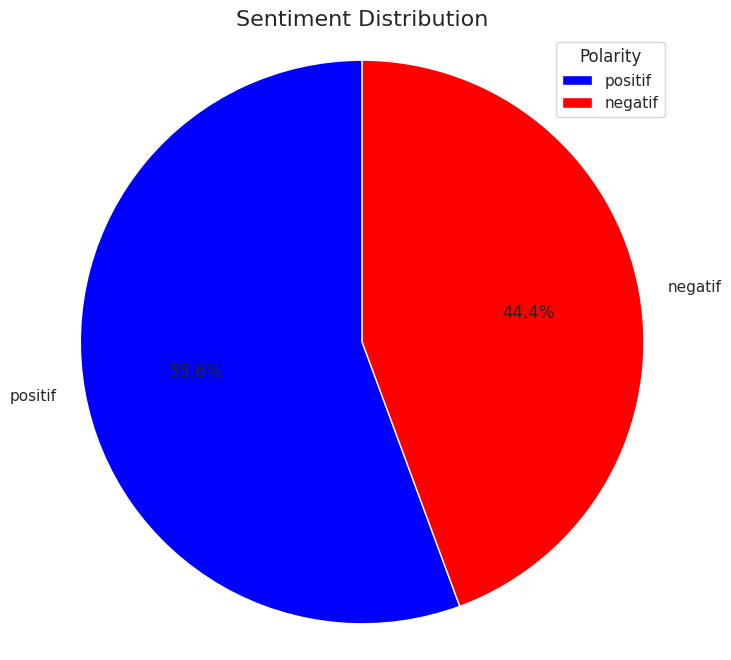

In [92]:
polarity_counts1 = df['ManualLabelling'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(polarity_counts1, labels=polarity_counts1.index, autopct='%1.1f%%', startangle=90, colors=['blue', 'red'])
plt.title('Sentiment Distribution', fontsize=16)
plt.axis('equal')

plt.legend(title="Polarity", loc="best")

plt.show()

#### **InSet Lexicon**

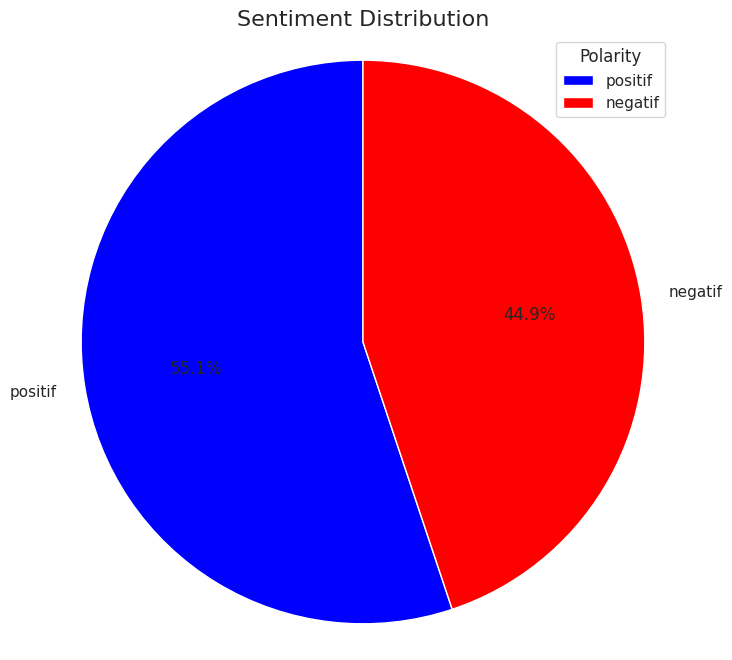

In [93]:
polarity_counts2 = df['inset_results'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(polarity_counts2, labels=polarity_counts2.index, autopct='%1.1f%%', startangle=90, colors=['blue', 'red'])
plt.title('Sentiment Distribution', fontsize=16)
plt.axis('equal')

plt.legend(title="Polarity", loc="best")

plt.show()

### **WordCloud**

#### **Positive Sentiment (InSet)**

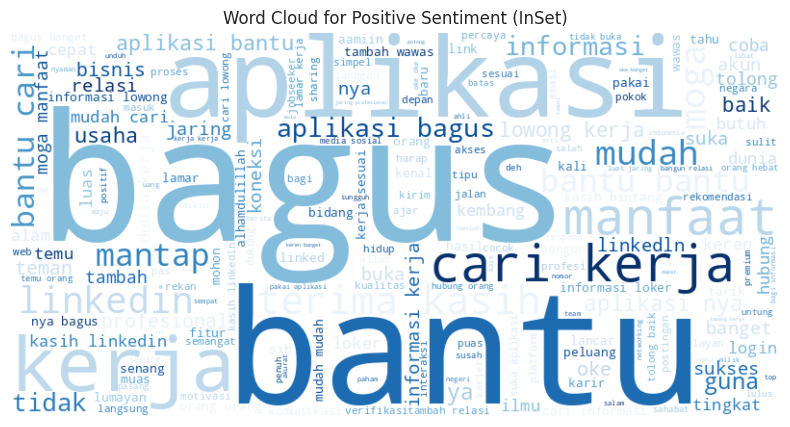

In [94]:
positive_reviews = df[df['inset_results'] == 'positif']['stemmed_review']
text_positive = ' '.join(positive_reviews)
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(text_positive)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment (InSet)')
plt.show()

#### **Positive Sentiment (Manual)**

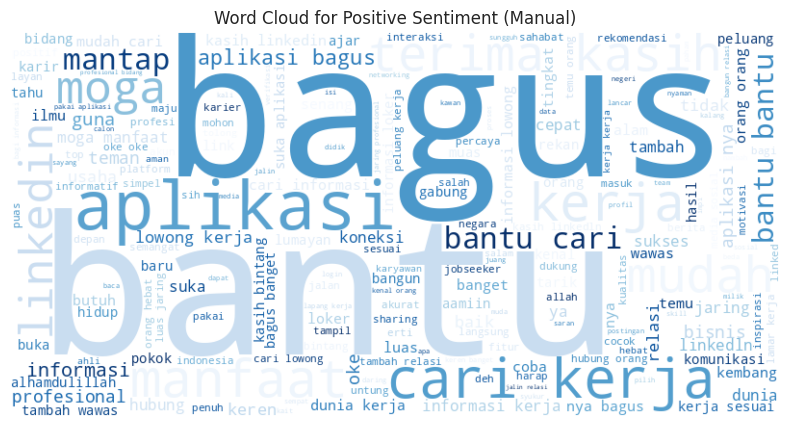

In [95]:
positive_reviews1 = df[df['ManualLabelling'] == 'positif']['stemmed_review']
text_positive1 = ' '.join(positive_reviews1)
wordcloud_positive1 = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(text_positive1)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive1, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment (Manual)')
plt.show()

#### **Negative Sentiment (InSet)**

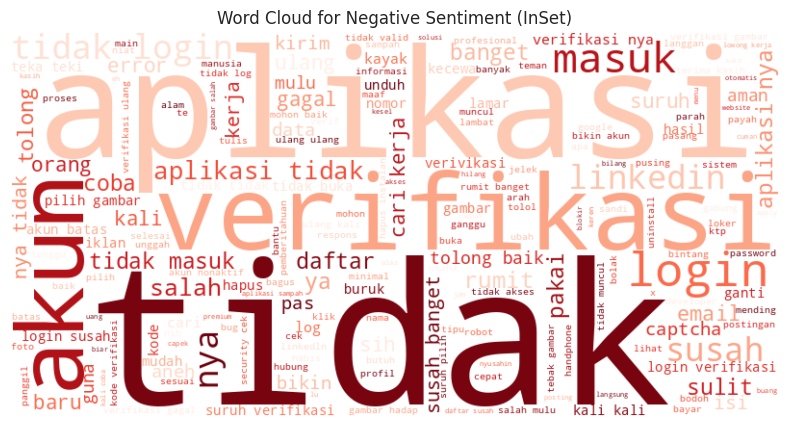

In [96]:
negative_reviews = df[df['inset_results'] == 'negatif']['stemmed_review']
text_negative = ' '.join(negative_reviews)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(text_negative)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Sentiment (InSet)')
plt.show()

#### **Negative Sentiment (Manual)**

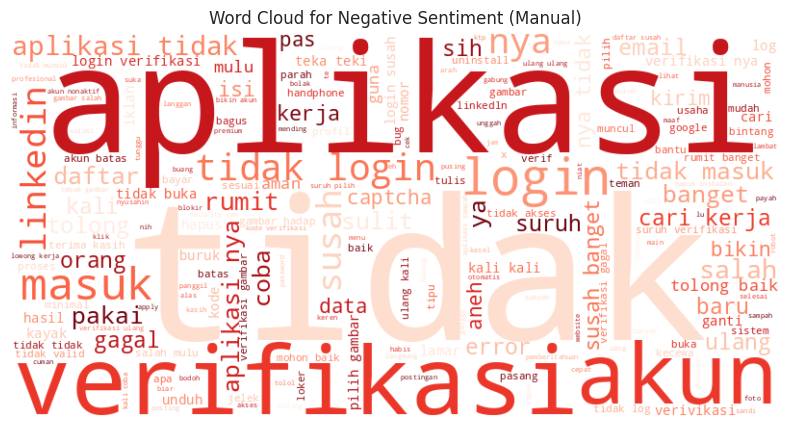

In [97]:
negative_reviews1 = df[df['inset_results'] == 'negatif']['stemmed_review']
text_negative1 = ' '.join(negative_reviews1)
wordcloud_negative1 = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(text_negative1)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative1, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Sentiment (Manual)')
plt.show()

## **Long Short-Term Memory (LSTM) Model**

### **InSet Lexicon**

In [98]:
X = df['stemmed_review']
y = df['inset_results']

In [99]:
len(X), len(y)

(4954, 4954)

In [100]:
embedding_dim = 100
max_length = 100
num_words = 5000

In [101]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index

In [102]:
X_seq = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_seq, maxlen=max_length)

In [103]:
sentences = [text.split() for text in X]
word2vec_model = Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4)
vocab_size = len(word_index) + 1

In [104]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

In [105]:
def lstm_model_with_word2vec(input_length, vocab_size, embedding_dim, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        input_length=input_length,
                        weights=[embedding_matrix],
                        trainable=False))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [106]:
ratios = [(0.9, 0.1), (0.8, 0.2), (0.7, 0.3), (0.6, 0.4), (0.5, 0.5), (0.4, 0.6), (0.3, 0.7), (0.2, 0.8), (0.1, 0.9)]

In [107]:
epoch_values = [10, 20, 30]

In [108]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [109]:
for train_size, test_size in ratios:
    print(f'\nTesting with train : test ratio of {train_size} : {test_size}')

    X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=test_size, random_state=42)

    for epochs in epoch_values:
        print(f'\nTraining with {epochs} epochs')

        model = lstm_model_with_word2vec(max_length, vocab_size, embedding_dim, embedding_matrix)

        history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_split=0.2, verbose=2)

        y_pred = model.predict(X_test)
        y_pred_classes = np.round(y_pred).astype(int)

        accuracy = accuracy_score(y_test, y_pred_classes)
        print(f'Accuracy for ratio {train_size} : {test_size} and {epochs} epochs = {accuracy * 100 :.2f}%')

        cm = confusion_matrix(y_test, y_pred_classes)
        print('Confusion Matrix :')
        print(cm)

        plt.figure(figsize=(6, 4))
        sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
        plt.title(f'Confusion Matrix for ratio {train_size} : {test_size} and {epochs} epochs')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.show()

        print('Classifiation Report :')
        print(classification_report(y_test, y_pred_classes, target_names=['Negative', 'Positive']))

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.title(f'Accuracy for ratio {train_size} : {test_size} and {epochs} epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f'Loss for ratio {train_size} : {test_size} and {epochs} epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.show()

Output hidden; open in https://colab.research.google.com to view.

### **Manual Labelling**

In [110]:
y1 = df['ManualLabelling']

In [111]:
le = LabelEncoder()
y1_encoded = le.fit_transform(y1)

In [112]:
def lstm_model_with_word2vec_manual(input_length, vocab_size, embedding_dim, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        input_length=input_length,
                        weights=[embedding_matrix],
                        trainable=False))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [113]:
for train_size, test_size in ratios:
    print(f'\nTesting with train : test ratio of {train_size} : {test_size}')

    X_train, X_test, y_train, y_test = train_test_split(X_padded, y1_encoded, test_size=test_size, random_state=42)

    for epochs in epoch_values:
        print(f'\nTraining with {epochs} epochs')

        model = lstm_model_with_word2vec_manual(max_length, vocab_size, embedding_dim, embedding_matrix)

        history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_split=0.2, verbose=2)

        y_pred = model.predict(X_test)
        y_pred_classes = np.round(y_pred).astype(int)

        accuracy = accuracy_score(y_test, y_pred_classes)
        print(f'Accuracy for ratio {train_size} : {test_size} and {epochs} epochs = {accuracy * 100 :.2f}%')

        cm = confusion_matrix(y_test, y_pred_classes)
        print('Confusion Matrix :')
        print(cm)

        plt.figure(figsize=(6, 4))
        sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
        plt.title(f'Confusion Matrix for ratio {train_size} : {test_size} and {epochs} epochs')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.show()

        print('Classifiation Report :')
        print(classification_report(y_test, y_pred_classes, target_names=['Negative', 'Positive']))

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.title(f'Accuracy for ratio {train_size} : {test_size} and {epochs} epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f'Loss for ratio {train_size} : {test_size} and {epochs} epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.show()

Output hidden; open in https://colab.research.google.com to view.